In [ ]:
# Learn additional capabilities (e.g., visualization) of Python and Jupyter, and use them to build an interactive notebook for visualizing
# or exploring the cryptocurrency market related dataset of your choice. Your interactive notebook should interact with Spark, so that it
# will be capable of supporting exploration of data sets that are too large to fit in the memory of a single machine.

# Scope/Relevance: Is the objective clear? Is the project related, course-related, and substantial enough?
# Methodology: Is the methodology appropriate and clearly described?
# Evaluation: Did you evaluate your work? Did you achieve your objective? If not, did you explain why not?
# Presentation: Is your video report well organized and clear?

!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [ ]:
from google.colab import files
upload = files.upload()

Saving crypto_tradinds.csv to crypto_tradinds.csv


In [ ]:
# Our goals include analyzing the following:
# On-Balance Volume (OBV)
# Moving Average Convergence Divergence (MACD)

# First, we load the dataset, and clean it.
crypto_raw = spark.read.csv("crypto_tradinds.csv", header = True, inferSchema = True).drop("site_url", "github_url", "industry_name")
#crypto_raw = crypto_raw.fillna(value = -99, subset = ["crypto_name"])#.filter(crypto_raw.crypto_name!= -99)

In [ ]:
from pyspark.sql.functions import *
#crypto_raw.count()
crypto_raw1 = crypto_raw.filter(col("crypto_name").isNotNull())


In [ ]:
# Relative Strength Index (RSI)
#crypto_raw1.show()
from math import floor
from pyspark.sql.types import IntegerType
def four_to_the_floor(x):
  return (floor(x / 14))

four_udf = udf(lambda x: four_to_the_floor(x), IntegerType())
#crypto_raw1 = crypto_raw1.withColumn("volume", )



#price_usd = crypto_raw1.select("USD_price_change_1_day", "volume").rdd.flatMap(lambda x: x).collect()

# 14-day period, calculated in two parts first by calculating RSI initially, then iteratively: for the first 14 days, we calculate
# First, we create

# On-Balance Volume - if today's close price is greater than yesterday's close, add the close price to OBV, and subtract if it is less than.


# Moving Average Convergence Divergence -

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *

windowSpec = Window.partitionBy("crypto_name").orderBy("trade_date")

crypto_count = crypto_raw1.groupBy(crypto_raw1.crypto_name.alias("name")).count()
crypto_total = crypto_raw1.join(crypto_count, crypto_raw1.crypto_name == crypto_count.name, 'left').drop("name")
crypto_total = crypto_total.select("*").filter("count > 1700")
crypto_total = crypto_total.withColumn("id", row_number().over(windowSpec))
crypto_total = crypto_total.withColumn("period", floor(crypto_total.id / 14))
crypto_total.show()

In [ ]:
# First, we would like our Bitcoin data
#bitcoin_data = crypto_total.select("*").filter("name == Bitcoin")
#select("*").filter("crypto_name = Bitcoin")
bitcoin_data = crypto_total.select("*").filter("crypto_name = 'Bitcoin'")
# We could also use Ethereum data
ether_data = crypto_total.select("*").filter("crypto_name = 'Ethereum'")



In [ ]:
bitcoin_data = bitcoin_data.select("*").orderBy("trade_date")
ether_data = ether_data.select("*").orderBy("trade_date")

In [ ]:
# We want to create OTP for the following datasets, now ordered by
windowid = Window.partitionBy("crypto_name").orderBy("trade_date")
bitcoin_data = bitcoin_data.select("*").withColumn("id", row_count().over(windowSpec))

bitcoin_data.show()

+-------------------+------------+---------+---------+-------------+---------------------------+----------------------+----------------------+-----------+-----------+------+----------+-------+-------------+---+-----+
|         trade_date|      volume|price_usd|price_btc|   market_cap|capitalization_change_1_day|USD_price_change_1_day|BTC_price_change_1_day|crypto_name|crypto_type|ticker|max_supply|minable|platform_name| id|count|
+-------------------+------------+---------+---------+-------------+---------------------------+----------------------+----------------------+-----------+-----------+------+----------+-------+-------------+---+-----+
|2016-01-01 00:00:00|   3.62789E7|   434.33|      1.0|6.529299589E9|                        0.0|                   0.0|                   0.0|    Bitcoin|          0|   BTC|  21000000|      1|          XRP|  0| 1746|
|2016-01-02 00:00:00|   3.00966E7|   433.44|      1.0|6.517390487E9|        -0.0018239478580617|   -0.0020491331476066|             

In [ ]:

windowSpec = Window.partitionBy("crypto_name").orderBy("trade_date")
windowval = Window.partitionBy("crypto_name").orderBy("trade_date").rangeBetween(Window.unboundedPreceding, 0)

lagged_data = crypto_total.select("*").withColumn("lag", lag("USD_price_change_1_day", 1).over(windowSpec))
lagged_data = lagged_data.withColumn("OBV", when(lagged_data.USD_price_change_1_day > lagged_data.lag, lagged_data.volume).when(lagged_data.USD_price_change_1_day < lagged_data.lag, - lagged_data.volume).otherwise(0))
lagged_data = lagged_data.withColumn("OBV", when(lagged_data.lag.isNull(), lagged_data.volume).otherwise(lagged_data.OBV))
lagged_data = lagged_data.withColumn("OBV", sum(lagged_data.OBV).over(windowval))
lagged_data = lagged_data.drop("lag")



In [ ]:
# Average gain over last
multi_window = Window.partitionBy("crypto_name", "period").orderBy("gain")
lag_window = Window.partitionBy("crypto_name").orderBy("period")

RSI_table = lagged_data.withColumn("gain_loss", when(lagged_data.USD_price_change_1_day > 0, lit(1)).when(lagged_data.USD_price_change_1_day < 0, lit(-1)).otherwise(0))

RSI_table = RSI_table.groupBy("crypto_name", "period", "gain_loss").agg(sum("USD_price_change_1_day").alias("avg_change")).orderBy("crypto_name", "period")

RSI_table = RSI_table.filter(RSI_table.avg_change != 0).withColumn("gain", when(RSI_table.gain_loss > 0, RSI_table.avg_change)).withColumn("loss", when(RSI_table.gain_loss < 0, RSI_table.avg_change)).drop("avg_change")
RSI_table = RSI_table.withColumn("gain", when(isnull(RSI_table.gain), RSI_table.loss).otherwise(RSI_table.gain)).drop("loss")
RSI_table = RSI_table.withColumn("loss", lag(RSI_table.gain, 1).over(multi_window))
RSI_table = RSI_table.dropna()

RSI_table = RSI_table.withColumn("RSI", when(RSI_table.period == 0, RSI_table.gain / - RSI_table.loss).otherwise(lag(RSI_table.gain, 1).over(lag_window) * 13 + RSI_table.gain / (- lag(RSI_table.loss, 1).over(lag_window) * 13 - RSI_table.loss)))
RSI_table = RSI_table.withColumn("RSI_1", 100 - (100 / (1 + RSI_table.RSI)))
#RSI_table = RSI_table.where(RSI_table.loss < 0)
#RSI_table.show()
#RSI_table = RSI_table.withColumn("RSI", )

#RSI_table.show()


In [ ]:
lagged_data = lagged_data.join(RSI_table, ["crypto_name", "period"])

lagged_data = lagged_data.drop("RSI", "gain", "loss", "gain_loss")
lagged_data = lagged_data.withColumnRenamed("RSI_1", "RSI")

In [ ]:
lagged_data.show()

+-----------+------+-------------------+------+---------+------------------+----------+---------------------------+----------------------+----------------------+-----------+------+----------+-------+-------------+-----+----+---------+-----------------+
|crypto_name|period|         trade_date|volume|price_usd|         price_btc|market_cap|capitalization_change_1_day|USD_price_change_1_day|BTC_price_change_1_day|crypto_type|ticker|max_supply|minable|platform_name|count|  id|      OBV|              RSI|
+-----------+------+-------------------+------+---------+------------------+----------+---------------------------+----------------------+----------------------+-----------+------+----------+-------+-------------+-----+----+---------+-----------------+
|    42-coin|    73|2018-11-29 00:00:00| 326.0| 23217.94|   5.4262103135188|  975153.0|         -0.089923817576553|    -0.089924388819423|     -0.09448237060135|          0|    42|      null|      1|          XRP| 1709|1022| 182326.0|91.5951

In [ ]:
bitcoin_data = lagged_data.filter(lagged_data.crypto_name == "Bitcoin").select("trade_date", "volume", "price_usd", "OBV", "RSI").toPandas()
ether_data = lagged_data.filter(lagged_data.crypto_name == "Ethereum").select("trade_date", "volume", "price_usd", "OBV", "RSI").toPandas()


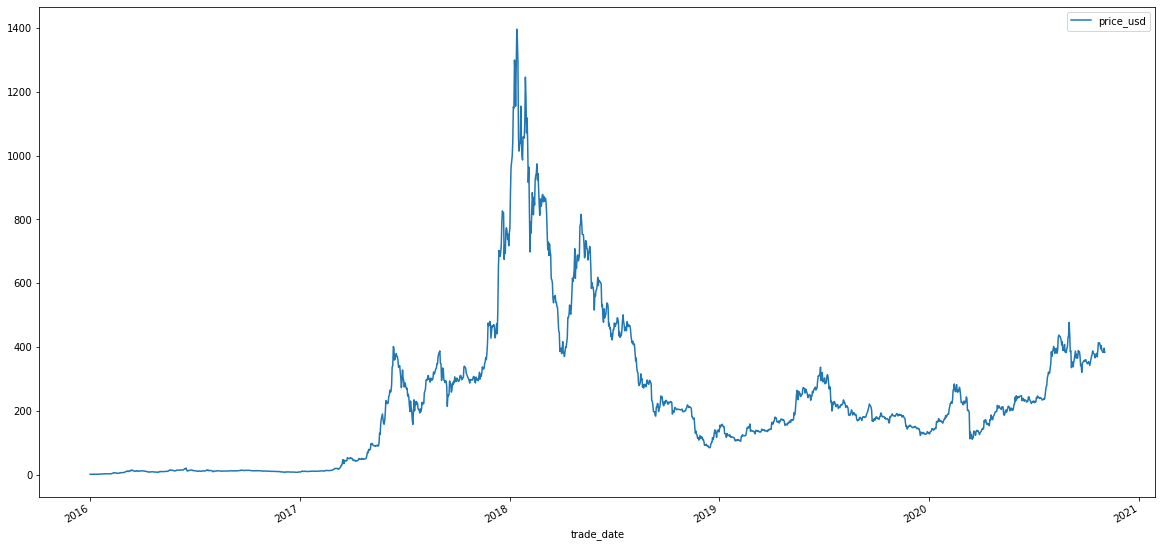

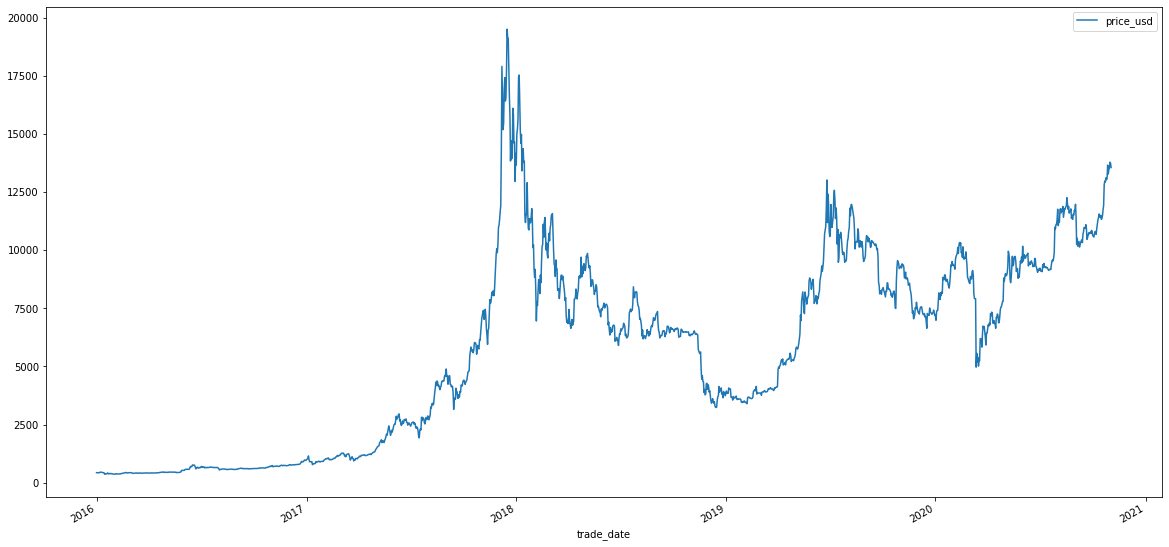

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (20, 10)

ether_data.plot.line(x = "trade_date", y = "price_usd")
bitcoin_data.plot.line(x = "trade_date", y = "price_usd")

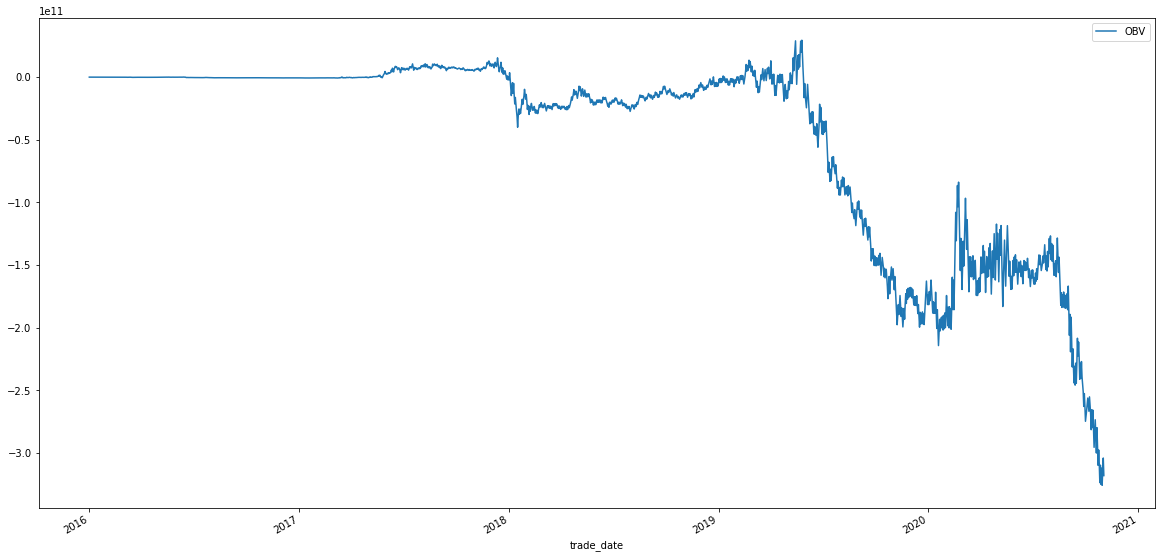

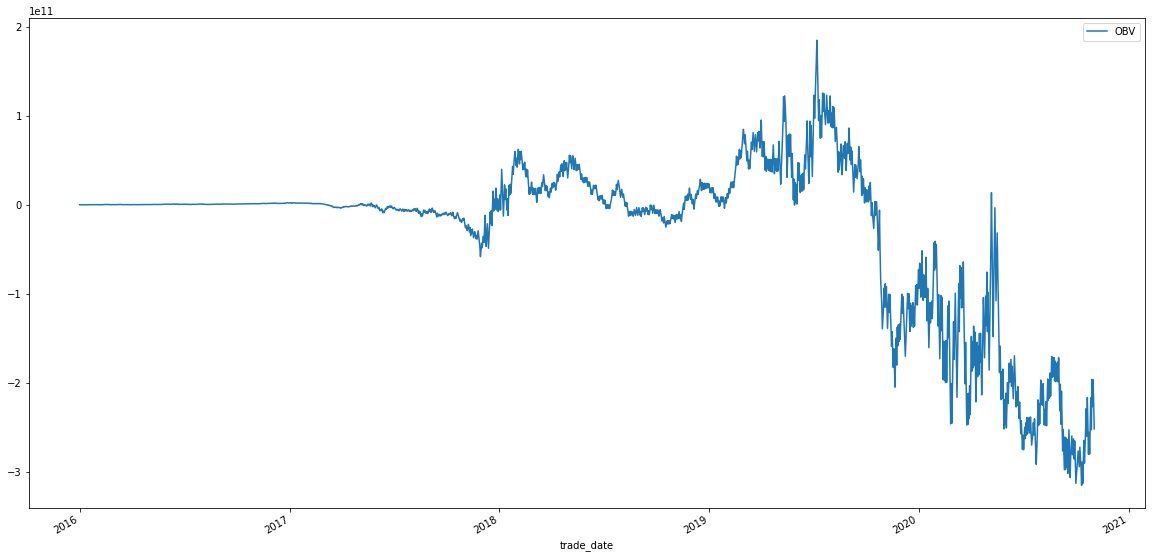

In [ ]:
ether_data.plot.line(x = "trade_date", y = "OBV")
bitcoin_data.plot.line(x = "trade_date", y = "OBV")

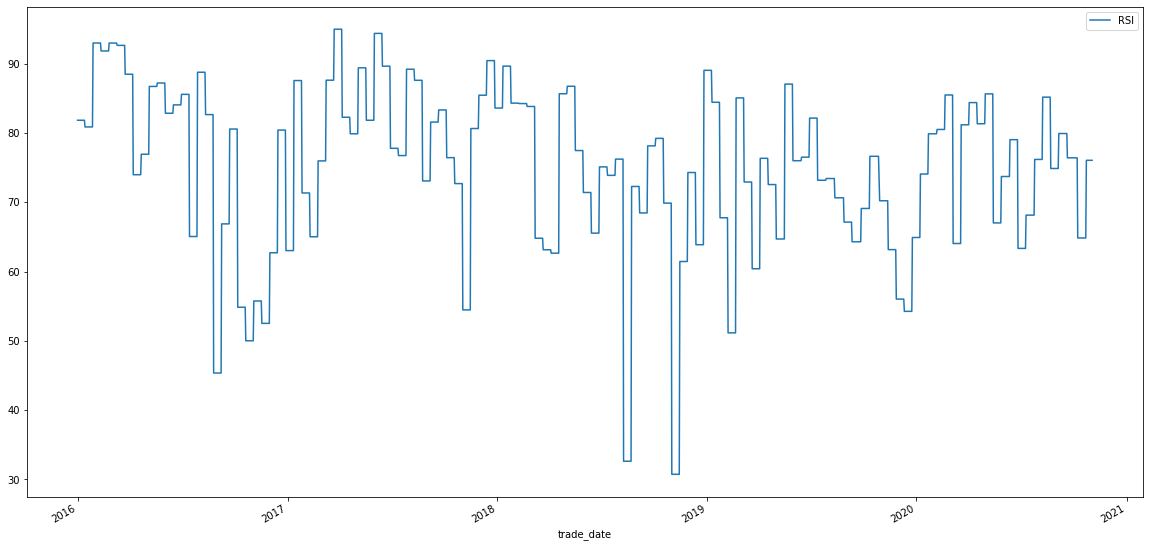

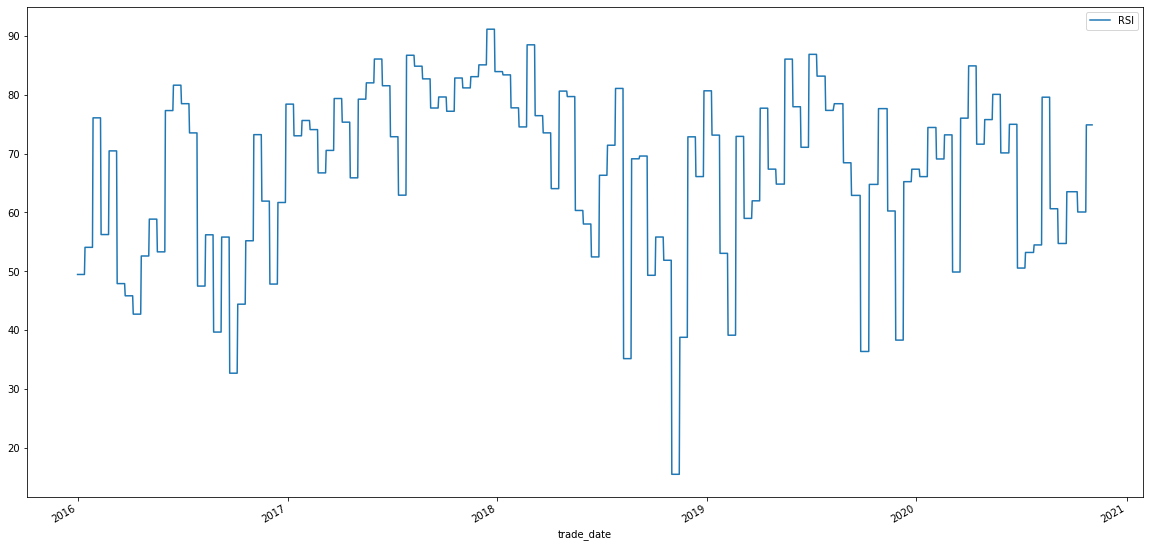

In [ ]:
ether_data.plot.line(x = "trade_date", y = "RSI")
bitcoin_data.plot.line(x = "trade_date", y = "RSI")